
<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/nngp_nas/NNGP_on_NASBench101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Colab demonstration for NNGP evaluation.

This colab accompanies the paper [**Towards NNGP-guided Neural Architecture Search**](). We construct an NNGP evaluator of networks in the [**NAS-Bench-101**](http://proceedings.mlr.press/v97/ying19a.html) dataset, and compute some metrics on how well it predicts the ground truth performance of the networks.

The publicly available and free hosted colab instances can be used to run this colab. This colab uses the NAS-Bench-101 package, which can be found at https://github.com/google-research/nasbench.

In [ ]:
# NAS-Bench-101 uses TF 1.x
%tensorflow_version 1.x

# Download the raw data (only 108 epoch data points).
!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

# Clone and install the code and dependencies.
!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Load NAS-Bench-101 data.
# This will take a while, and should only be run once.
nasbench_only108 = api.NASBench('nasbench_only108.tfrecord')

# Imports and Definitions

We define some useful constants and the `NNGP_CIFAR10_Evaluator` to be used for NNGP evaluation of networks.

In [ ]:
#@title Imports

import numpy as np
import scipy
import scipy.stats as stats
import sklearn
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

from nasbench import api
from nasbench.lib import cifar
from nasbench.lib import base_ops
from nasbench.lib import model_builder

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [ ]:
#@title Useful Constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

# Default config for building architecture
_CIFAR_DEFAULT_CONFIG = {
    'nasbench_stem_filter_size': 128,
    'nasbench_num_modules_per_stack': 3,
    'nasbench_num_stacks': 3,
    'nasbench_data_format': 'channels_last',
    'nasbench_num_labels': 10,
}

# Pixel statistics for CIFAR10.
CIFAR_MEAN = np.array([125.3, 123.0, 113.9])
CIFAR_STDDEV = np.array([63.0, 62.1, 66.7])

In [ ]:
#@title Helper functions

def one_hot_cifar(label_batch):
  """One-hot function for CIFAR10.
  
  Args:
    Batch of labels.

  Returns:
    Batch of adjusted one-hot labels with mean-zero.
  """
  return np.array([[float(x==i) - 0.1 for i in range(10)] for x in label_batch])

def build_model_fn(spec, config):
  """Returns a model function returning a feature vector."""
  if config['nasbench_data_format'] == 'channels_last':
    channel_axis = 3
  elif config['nasbench_data_format'] == 'channels_first':
    # Currently this is not well supported
    channel_axis = 1
  else:
    raise ValueError('invalid nasbench_data_format')

  def model_fn(features, is_training):
    """Returns feature vector and training op from the input features.
    
    Args:
      features: Input features.
      is_training: Bool indicating whether to update batch-norm parameters.
        Batch-norm parameters are updated when set to `true`.

    Returns:
      (net, train_op)
      net: Feature vectors from penultimate layer of network.
      train_op: Batch-normalization op.
    """
    # Initial stem convolution
    with tf.variable_scope('stem'):
      net = base_ops.conv_bn_relu(
          features, 3, config['nasbench_stem_filter_size'],
          is_training, config['nasbench_data_format'])
    for stack_num in range(config['nasbench_num_stacks']):
      channels = net.get_shape()[channel_axis].value
      # Downsample at start (except first)
      if stack_num > 0:
        net = tf.layers.max_pooling2d(
            inputs=net,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            data_format=config['nasbench_data_format'])
        # Double output channels each time we downsample
        channels *= 2
      with tf.variable_scope('stack{}'.format(stack_num)):
        for module_num in range(config['nasbench_num_modules_per_stack']):
          with tf.variable_scope('module{}'.format(module_num)):
            net = model_builder.build_module(
                spec,
                inputs=net,
                channels=channels,
                is_training=is_training)
    # Global average pool
    if config['nasbench_data_format'] == 'channels_last':
      net = tf.reduce_mean(net, [1, 2])
    elif config['nasbench_data_format'] == 'channels_first':
      net = tf.reduce_mean(net, [2, 3])
    else:
      raise ValueError('invalid nasbench_data_format')

    # Define the training op as the update ops in the graph.
    # The results in the training op being set to batch-norm updates.
    train_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    train_op_w = tf.group(*train_ops)

    return net, train_op_w

  return model_fn

In [ ]:
#@title NNGP_CIFAR10_Evaluator

class NNGP_CIFAR10_Evaluator:
  """NNGP evaluator of models on CIFAR10."""

  def __init__(self,
               train_size,
               val_size,
               random_seed=0,
               config=_CIFAR_DEFAULT_CONFIG):
    """Initialize evaluator object.

    Args:
      train_size: Size of NNGP training set selected from CIFAR10 training set.
      val_size: Size of NNGP validation set selected from CIFAR10 training set.
      random_seed: Numpy random seed used for shuffing CIFAR10 training set.
      config: Configurations required to build network.
    """
    self.config = config
    self._random_seed = random_seed
    self._train_size = train_size
    self._val_size = val_size
    self._construct_dataset()

  def get_train_size(self):
    """Return NNGP training set size."""
    return self._train_size

  def get_val_size(self):
    """Return NNGP validation set size."""
    return self._val_size

  def _construct_dataset(self):
    """Construct dataset for NNGP training and evaluation from CIFAR10.

    Args:
      train_size: Size of NNGP training set selected from CIFAR10 training set.
      val_size: Size of NNGP validation set selected from CIFAR10 training set.
    """
    train_size = self._train_size
    val_size = self._val_size
    random_seed = self._random_seed

    assert train_size + val_size <= 50000

    # Load CIFAR10 training set
    ds, _ = tfds.load('cifar10', split='train', batch_size=-1, with_info=True)
    ds = tfds.as_numpy(ds)

    # Shuffle index
    np.random.seed(random_seed)
    shuffled = np.arange(50000)
    np.random.shuffle(shuffled)
    train_index = shuffled[:train_size]
    val_index = shuffled[-val_size:]

    # Select training subset and validation subset.
    train_images = ds['image'][train_index]
    train_images = (train_images - CIFAR_MEAN) / CIFAR_STDDEV
    train_labels = ds['label'][train_index]

    val_images = ds['image'][val_index]
    val_images = (val_images - CIFAR_MEAN) / CIFAR_STDDEV
    val_labels = ds['label'][val_index]

    self.data_dict = dict(train_images=train_images,
                          train_labels=train_labels,
                          val_images=val_images,
                          val_labels=val_labels)
    
    del ds

  def nngp_eval(self,
                spec,
                batch_size=100,
                ensemble_number=4,
                verbose=False):
    """Evaluate NAS-Bench-101 model using NNGP evaluation.

    Args:
      spec: ModelSpec object.
      batch_size: Batch size to use for NNGP training and evaluation.
        The batch size must divide training and val set size.
      ensemble_number: Ensemble number for monte-carlo NNGP kernel estimation.

    Returns:
      NNGP validation accuracy.
    """

    # Get data
    data_dict = self.data_dict
    train_images = data_dict['train_images']
    train_labels = data_dict['train_labels']
    val_images = data_dict['val_images']
    val_labels = data_dict['val_labels']

    n_t = len(train_labels)
    n_v = len(val_labels)

    # Initialize Kernel matrices.
    K_tt = np.zeros((n_t,n_t),dtype=np.float32)
    K_vt = np.zeros((n_v,n_t),dtype=np.float32)
    assert n_t % batch_size == 0, (
        "Batch size does not divide training set size.")
    assert n_v % batch_size == 0, (
        "Batch size does not divide validation set size.")
    
    model_fn = build_model_fn(spec, self.config)

    with tf.Graph().as_default():
      features = tf.placeholder(dtype=tf.float32, shape=[batch_size, 32, 32, 3])
      is_training = tf.placeholder(dtype=tf.bool, name='is_training')
      vecs, ops = model_fn(features, is_training)
      tf.logging.info("Model constructed.")
      for curr_m in range(ensemble_number):
        with tf.Session() as sess:
          sess.run(tf.global_variables_initializer())
          # Set batch norm parameters using random batch of training set.
          init_ind = np.random.choice(
              n_t, batch_size, replace=False)
          init_sample = train_images[init_ind]
          _ = sess.run(ops,
                      feed_dict={features: init_sample, is_training: True})
          # Get train feature vectors.
          fvecs = []
          iterations = n_t // batch_size
          for i in range(iterations):
            feed = train_images[batch_size * i:batch_size * (i+1)]
            vres = sess.run([vecs],
                            feed_dict={features: feed, is_training: False})
            fvecs += vres
          fvecs_t = np.concatenate(fvecs, axis=0)
          # Update K_tt using train feature vectors.
          K_tt += np.matmul(fvecs_t, fvecs_t.T) * (1.0/ensemble_number)
          # Get validation feature vectors.
          fvecs = []
          iterations = n_v // batch_size
          for i in range(iterations):
            feed = val_images[batch_size * i:batch_size * (i+1)]
            vres = sess.run([vecs],
                            feed_dict={features: feed, is_training: False})
            fvecs += vres
          fvecs_v = np.concatenate(fvecs, axis=0)
          # Update K_vt using val feature vetors.
          K_vt += np.matmul(fvecs_v, fvecs_t.T) * (1.0/ensemble_number)
          
      performance = 0.0
      # Range of regularizer set manually.
      diag_reg_values = np.logspace(-7, 2, num=20)
      one_hot_labels_t = one_hot_cifar(train_labels)
      for epsilon in diag_reg_values:
        # Regularize K_tt.
        K_tt_reg = K_tt + epsilon * np.trace(K_tt) / n_t * np.eye(n_t)
        # 'try' statement, since scipty.linalg.solve can fail.
        try:
          # Perform NNGP inference to obtain validation accuracy.
          inv_labels = scipy.linalg.solve(
              K_tt_reg, one_hot_labels_t, sym_pos=True)
          prediction = np.matmul(K_vt, inv_labels)
          correct_predictions = (
              np.argmax(prediction, axis=1) == val_labels).astype(np.float32)
          performance = max(performance, np.mean(correct_predictions))
        except:
          if verbose:
            print("Matrix inversion error for epsilon = {}".format(epsilon))
          continue
    
    return performance

# Single example

Here we construct a single network cell spec and compute its NNGP validation accuracy.

In [ ]:
# Construct evaluator.
evaluator = NNGP_CIFAR10_Evaluator(train_size=500, val_size=200)

In [ ]:
# Build ModelSpec of Inception-like cell.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Perform NNGP inference using evaluator to obtain NNGP validation accuracy.
nngp_validation_accuracy = evaluator.nngp_eval(cell, batch_size=100, ensemble_number=4)

print("NNGP validation accuracy:")
print(nngp_validation_accuracy)

NNGP validation accuracy:
0.38


In [ ]:
evaluator.data_dict['train_labels']

array([8, 9, 3, 7, 6, 3, 3, 9, 8, 7, 6, 4, 2, 1, 9, 1, 3, 9, 3, 7, 9, 9,
       5, 8, 1, 7, 2, 8, 0, 3, 3, 7, 8, 9, 1, 3, 5, 4, 8, 3, 8, 3, 7, 7,
       6, 9, 3, 5, 4, 7, 9, 0, 9, 9, 7, 2, 4, 7, 8, 1, 9, 4, 8, 7, 2, 0,
       1, 1, 6, 0, 3, 4, 5, 6, 4, 6, 9, 5, 1, 7, 7, 6, 2, 8, 2, 8, 4, 0,
       5, 5, 3, 0, 4, 4, 0, 6, 2, 8, 9, 9, 8, 2, 6, 2, 9, 7, 0, 9, 8, 9,
       6, 6, 5, 7, 3, 6, 0, 4, 9, 3, 0, 4, 0, 2, 7, 4, 1, 1, 6, 0, 5, 0,
       0, 8, 3, 1, 4, 6, 4, 5, 6, 1, 6, 1, 1, 7, 1, 2, 3, 9, 3, 5, 8, 2,
       0, 0, 4, 9, 0, 0, 8, 9, 5, 7, 8, 5, 3, 6, 7, 6, 7, 9, 2, 6, 3, 7,
       8, 1, 8, 3, 9, 4, 0, 3, 0, 0, 3, 9, 3, 6, 4, 2, 3, 5, 9, 6, 2, 5,
       7, 4, 4, 4, 1, 2, 2, 4, 2, 9, 7, 8, 7, 1, 7, 9, 1, 3, 1, 4, 3, 6,
       9, 4, 9, 2, 1, 5, 8, 0, 2, 3, 9, 3, 9, 9, 0, 2, 9, 7, 9, 7, 9, 9,
       6, 1, 6, 5, 1, 8, 9, 4, 5, 5, 6, 9, 9, 8, 2, 8, 2, 8, 2, 8, 1, 8,
       3, 5, 1, 6, 2, 3, 2, 2, 0, 8, 3, 5, 1, 8, 9, 8, 0, 1, 7, 4, 1, 8,
       8, 8, 2, 6, 9, 0, 4, 1, 4, 3, 5, 1, 0, 2, 0,

In [ ]:
ds, _ = tfds.load('cifar10', split='train', batch_size=-1, with_info=True)
ds = tfds.as_numpy(ds)
ds['label'][:20]

array([7, 8, 4, 4, 6, 5, 2, 9, 6, 6, 9, 9, 3, 0, 8, 7, 9, 0, 4, 9])

# NNGP inference on subsets of NAS-Bench-101

Let us now select 50 random networks from the NAS-Bench-101 dataset and plot the ground-truth performance (obtained by taking the average of the final test set accuracy after 108-epoch training) against NNGP validation accuracy.

While we set the NNGP training and validation set size to 100, and the ensemble number to 2 here for rapid evaluation, these parameters may be adjusted.

We also compute some basic metrics on how well the NNGP validation accuracy predicts the ground truth performance.

In [ ]:
#@title Function defs

def random_specs(oracle, num, random_seed=12345):
  """Returns a list of valid specs in oracle.
  
  Args:
    oracle: An api.NASBench object.
    num: Number of specs to return.

  Returns:
    A list of random valid specs from oracle.
  """
  specs = []
  hashes = set([])
  
  np.random.seed(random_seed)
  while len(specs) < num:
    # Find a valid random spec.
    while True:
      matrix = np.random.choice(ALLOWED_EDGES,
                                size=(NUM_VERTICES, NUM_VERTICES))
      matrix = np.triu(matrix, 1)
      ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
      ops[0] = INPUT
      ops[-1] = OUTPUT
      spec = api.ModelSpec(matrix=matrix, ops=ops)
      if oracle.is_valid(spec):
        break
    # Check if spec is already in collected set.
    h = spec.hash_spec(ALLOWED_OPS)
    if h in hashes:
      continue
    specs += [spec]
    hashes.add(h)

  return specs


def mean_108epoch_performance(spec, oracle):
  """Returns the mean performance of model after 108-epoch training.

  Args:
    spec: ModelSpec.
    oracle: An api.NASBench object containing final_test_accuracy for
      108-epoch training.

  Returns:
    Mean final_test_accuracy of model built from spec upon 108-epoch training.
  """
  result = np.mean([d['final_test_accuracy']
                    for d in oracle.get_metrics_from_spec(spec)[1][108]])

  return result

## Experiment

Let us run the experiment and present performance metrics.

This make take up to ~30 mins on a GPU (V100) instance.

In [ ]:
# Experiment configurations
NUM_SPECS = 250
RANDOM_SEED = 123
TRAIN_SIZE = 100
VAL_SIZE = 200
BATCH_SIZE = 100
ENSEMBLE_NUMBER = 2

In [ ]:
# Get 250 random specs from NAS-Bench-101 dataset.
nasbench_specs = random_specs(
    oracle=nasbench_only108, num=NUM_SPECS, random_seed=RANDOM_SEED)

# Construct NNGP evaluator.
evaluator = NNGP_CIFAR10_Evaluator(train_size=TRAIN_SIZE, val_size=VAL_SIZE)

# Retrieve mean 108-epoch trained test-accuracy for the 250 specs.
ground_truth = [
                mean_108epoch_performance(spec=spec, oracle=nasbench_only108) 
                for spec in nasbench_specs
                ]

In [ ]:
# Compute NNGP validation accuracy for the 250 specs.
nngp_val = [
            evaluator.nngp_eval(spec, batch_size=BATCH_SIZE, 
                                ensemble_number=ENSEMBLE_NUMBER) 
            for spec in tqdm(nasbench_specs)
            ]

## Analysis

### Ground Truth vs. NNGP Validation Accuracy Plot

We plot the groud truth accuracy against NNGP validation accuracy.

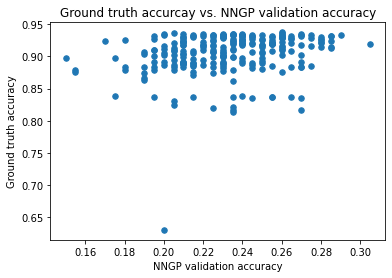

In [ ]:
# Compare ground-truth accuracy against NNGP 
plt.title("Ground truth accurcay vs. NNGP validation accuracy")
plt.scatter(nngp_val, ground_truth, s=30)
plt.xlabel("NNGP validation accuracy")
plt.ylabel("Ground truth accuracy")

plt.show()

### Metrics

We compute metrics used in [**Towards NNGP-guided Neural Architecture Search**]() to evaluate how well NNGP accuracy predicts the ground truth performance of the 250-network subset selected.

See paper for more information on the metrics.

In [ ]:
# Kendall's tau.
tau, _ = stats.kendalltau(ground_truth, nngp_val)
print("Kendall's Tau: {}".format(tau))

# Pearson Correlation
corr, _ = stats.pearsonr(ground_truth, nngp_val)
print("Correlation Coefficient: {}".format(corr))

# Discovered Performance
# Sort networks according to NNGP performance
sorted_networks = np.argsort(nngp_val) 
# Get best ground-truth performance of the top-10 networks according to NNGP performance.
discovered_performance = np.max(np.array(ground_truth)[sorted_networks[-10:]]) 
print("Discovered Performance: {}".format(discovered_performance))

Kendall's Tau: 0.1827665761509062
Correlation Coefficient: 0.21632201735448991
Discovered Performance: 0.9337606827418009


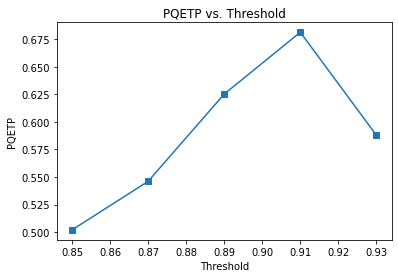

In [ ]:
# Prediction Quality for Exceedance of Threshold Performance p_T (PQETP-p_T)
def pqetp(ground_truth, performance_metric, threshold):
  """Returns PQETP_threshold with respect to the performance metric."""
  return sklearn.metrics.roc_auc_score(
      (np.array(ground_truth) > threshold), performance_metric)

# PQETP plot.
threshold_values = [0.85, 0.87, 0.89, 0.91, 0.93]
pqetp_threshold = [
                   pqetp(ground_truth, nngp_val, p_T) 
                   for p_T in threshold_values
                   ]

plt.title("PQETP vs. Threshold")
plt.plot(threshold_values, pqetp_threshold, marker='s')
plt.xlabel("Threshold")
plt.ylabel("PQETP")

plt.show()

The quality of prediction improves as one increases NUM_SPECS, TRAIN_SIZE, VAL_SIZE, and ENSEMBLE_NUMBER. Evaluating on the full (423k) NASBench-101 models as done in the paper would require distributed computation. 